In [1]:
import os
import datetime
import IPython
import IPython.display
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow.keras import layers, models
import mplfinance as mpf
import yfinance as yf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense, InputLayer, RepeatVector, TimeDistributed, Flatten, ConvLSTM2D
from keras.optimizers import SGD
mpl.rcParams['figure.figsize'] = (6, 4)
mpl.rcParams['axes.grid'] = False

# DATASET

In [4]:
eurusd = yf.Ticker("EURUSD=X")
df = eurusd.history(period="max")
df.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2003-12-01 00:00:00+00:00,1.203398,1.204007,1.194401,1.196501,0,0.0,0.0
2003-12-02 00:00:00+00:00,1.196101,1.210903,1.194600,1.208897,0,0.0,0.0
2003-12-03 00:00:00+00:00,1.209000,1.213003,1.207700,1.212298,0,0.0,0.0
2003-12-04 00:00:00+00:00,1.212004,1.214403,1.204398,1.208094,0,0.0,0.0
2003-12-05 00:00:00+00:00,1.207802,1.219096,1.206593,1.218695,0,0.0,0.0


C:\Users\owner\anaconda3\lib\site-packages\mplfinance\plotting.py:694: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  volumeAxes.set_ylim(vymin,vymax)


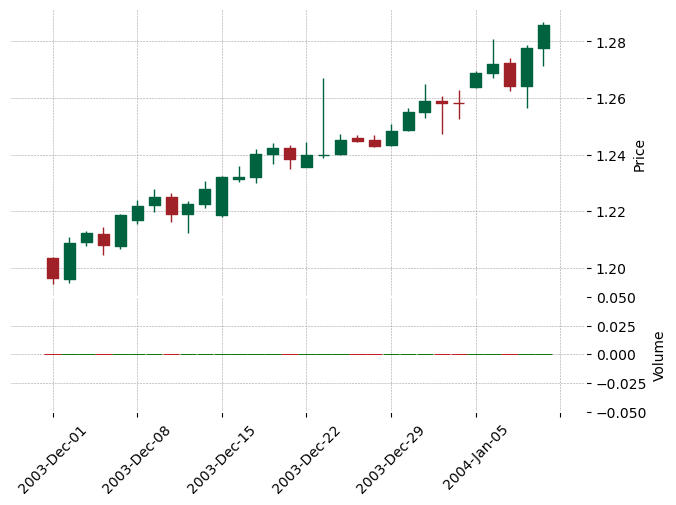

In [5]:
mpf.plot(df[:30], type='candle', style='charles', volume=True)

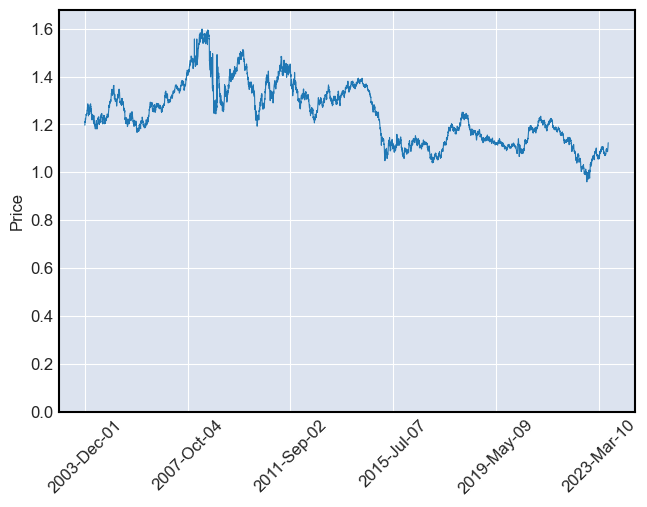

In [6]:
mpf.plot(df,type='line')

# Inspect, Cleanup and Feature Engineer

In [7]:
df.describe()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
count,5092.000000,5092.000000,5092.000000,5092.000000,5092.0,5092.0,5092.0
mean,1.240367,1.245020,1.235290,1.240391,0.0,0.0,0.0
std,0.125961,0.126664,0.126370,0.125954,0.0,0.0,0.0
min,0.959619,0.967006,0.072902,0.959619,0.0,0.0,0.0
25%,1.131001,1.134424,1.127196,1.131091,0.0,0.0,0.0
50%,1.228252,1.233494,1.223661,1.228139,0.0,0.0,0.0
75%,1.332529,1.337408,1.326962,1.332432,0.0,0.0,0.0
max,1.598184,1.602821,1.587402,1.598798,0.0,0.0,0.0


In [8]:
def clean_feature_eng(df):
    df=df.reset_index()
    df=df.drop(['Volume', 'Dividends', 'Stock Splits'], axis=1)
    df['Date']=pd.to_datetime(df['Date'], utc=True)
    df['hour_sin'] = np.sin(2 * np.pi * df['Date'].dt.hour / 24)
    df['hour_cos'] = np.cos(2 * np.pi * df['Date'].dt.hour / 24)
    df['day_sin'] = np.sin(2 * np.pi * df['Date'].dt.dayofyear / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['Date'].dt.dayofyear / 365)
    df['year_sin'] = np.sin(2 * np.pi * df['Date'].dt.year / (10*365))
    df['year_cos'] = np.cos(2 * np.pi * df['Date'].dt.year / (10*365))
    df.pop('Date')
    return df

In [9]:
df=clean_feature_eng(df)
df.head()

,Open,High,Low,Close,hour_sin,hour_cos,day_sin,day_cos,year_sin,year_cos
0,1.203398,1.204007,1.194401,1.196501,0.0,1.0,-0.493776,0.869589,-0.301641,-0.953422
1,1.196101,1.210903,1.194600,1.208897,0.0,1.0,-0.478734,0.877960,-0.301641,-0.953422
2,1.209000,1.213003,1.207700,1.212298,0.0,1.0,-0.463550,0.886071,-0.301641,-0.953422
3,1.212004,1.214403,1.204398,1.208094,0.0,1.0,-0.448229,0.893919,-0.301641,-0.953422
4,1.207802,1.219096,1.206593,1.218695,0.0,1.0,-0.432776,0.901502,-0.301641,-0.953422


In [10]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Open,5092.0,1.240367,0.125961,0.959619,1.131001,1.228252,1.332529,1.598184
High,5092.0,1.245020,0.126664,0.967006,1.134424,1.233494,1.337408,1.602821
Low,5092.0,1.235290,0.126370,0.072902,1.127196,1.223661,1.326962,1.587402
Close,5092.0,1.240391,0.125954,0.959619,1.131091,1.228139,1.332432,1.598798
hour_sin,5092.0,-0.150758,0.127649,-0.258819,-0.258819,-0.258819,0.000000,0.000000
hour_cos,5092.0,0.980152,0.016805,0.965926,0.965926,0.965926,1.000000,1.000000
day_sin,5092.0,0.022831,0.705052,-0.999991,-0.680773,0.043022,0.723644,0.999991
day_cos,5092.0,0.004252,0.708914,-0.999963,-0.708627,0.004304,0.714673,1.000000
year_sin,5092.0,-0.318407,0.009261,-0.334280,-0.326156,-0.318007,-0.309835,-0.301641
year_cos,5092.0,-0.947904,0.003111,-0.953422,-0.950790,-0.948088,-0.945316,-0.942474


Text(0.5, 1.0, 'Time of day signal')

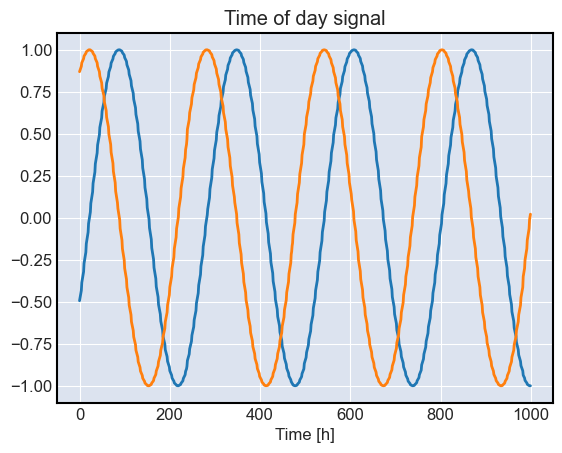

In [11]:
plt.plot(np.array(df['day_sin'])[:1000])
plt.plot(np.array(df['day_cos'])[:1000])
plt.xlabel('Time [h]')
plt.title('Time of day signal')

In [12]:
df.head()

,Open,High,Low,Close,hour_sin,hour_cos,day_sin,day_cos,year_sin,year_cos
0,1.203398,1.204007,1.194401,1.196501,0.0,1.0,-0.493776,0.869589,-0.301641,-0.953422
1,1.196101,1.210903,1.194600,1.208897,0.0,1.0,-0.478734,0.877960,-0.301641,-0.953422
2,1.209000,1.213003,1.207700,1.212298,0.0,1.0,-0.463550,0.886071,-0.301641,-0.953422
3,1.212004,1.214403,1.204398,1.208094,0.0,1.0,-0.448229,0.893919,-0.301641,-0.953422
4,1.207802,1.219096,1.206593,1.218695,0.0,1.0,-0.432776,0.901502,-0.301641,-0.953422


# Split the data

In [13]:
column_indices = {name: i for i, name in enumerate(df.columns)}

n = len(df)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

num_features = df.shape[1]

# Normalizing

In [14]:
train_mean = train_df.mean()
train_std = train_df.std()

train_df = (train_df - train_mean) / train_std
val_df = (val_df - train_mean) / train_std
test_df = (test_df - train_mean) / train_std

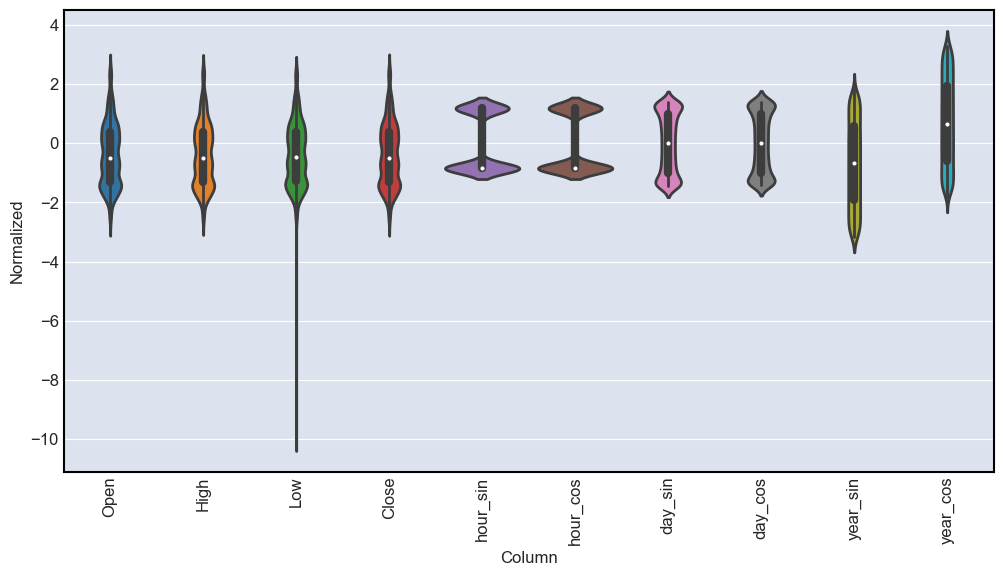

In [15]:
df_std = (df - train_mean) / train_std
df_std = df_std.melt(var_name='Column', value_name='Normalized')
plt.figure(figsize=(12, 6))
ax = sns.violinplot(x='Column', y='Normalized', data=df_std)
_ = ax.set_xticklabels(df.keys(), rotation=90)

# Data Windowing

In [17]:
class WindowGenerator():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):
        # Store the raw data.
        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df
        # Work out the label column indices.
        self.label_columns = label_columns
        if not label_columns == None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in enumerate(train_df.columns)}
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    def __repr__(self):
        return '\n'.join([f'Total window size: {self.total_window_size}', 
                          f'Input indices: {self.input_indices}',
                          f'Label indices: {self.label_indices}',
                          f'Label column name(s): {self.label_columns}'])
    


In [18]:
w5=WindowGenerator(input_width=5, label_width=5, shift=1, label_columns=['Open'])
w10=WindowGenerator(input_width=10, label_width=5, shift=1, label_columns=['Open'])
w5,w10


(Total window size: 6
 Input indices: [0 1 2 3 4]
 Label indices: [1 2 3 4 5]
 Label column name(s): ['Open'],
 Total window size: 11
 Input indices: [0 1 2 3 4 5 6 7 8 9]
 Label indices: [ 6  7  8  9 10]
 Label column name(s): ['Open'])

In [19]:
def split_window(self, features):
    inputs = features[:, self.input_slice, :]
    labels = features[:, self.labels_slice, :]
    if not self.label_columns == None:
        labels = tf.stack([labels[:, :, self.column_indices[name]] 
                           for name in self.label_columns],axis=-1)
    inputs.set_shape([None, self.input_width, None])
    labels.set_shape([None, self.label_width, None])

    return inputs, labels

WindowGenerator.split_window = split_window


# Test run the windows

In [20]:
example_window5 = tf.stack([np.array(train_df[:w5.total_window_size]),
                           np.array(train_df[100:100+w5.total_window_size]),
                           np.array(train_df[200:200+w5.total_window_size])])
example_window10 = tf.stack([np.array(train_df[:w10.total_window_size]),
                           np.array(train_df[100:100+w10.total_window_size]),
                           np.array(train_df[200:200+w10.total_window_size])])

example_inputs5, example_labels5 = w5.split_window(example_window5)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window5.shape}')
print(f'Inputs shape: {example_inputs5.shape}')
print(f'Labels shape: {example_labels5.shape}')

example_inputs10, example_labels10 = w10.split_window(example_window10)
print('All shapes are: (batch, time, features)')
print(f'Window shape: {example_window10.shape}')
print(f'Inputs shape: {example_inputs10.shape}')
print(f'Labels shape: {example_labels10.shape}')

All shapes are: (batch, time, features)
Window shape: (3, 6, 10)
Inputs shape: (3, 5, 10)
Labels shape: (3, 5, 1)
All shapes are: (batch, time, features)
Window shape: (3, 11, 10)
Inputs shape: (3, 10, 10)
Labels shape: (3, 5, 1)


# Creating tf.data.Datasets

In [21]:
def make_dataset(self, data):
    data = np.array(data, dtype=np.float32)
    ds = tf.keras.utils.timeseries_dataset_from_array(
        data=data, 
        targets=None, 
        sequence_length=self.total_window_size,
        sequence_stride=1,
        shuffle=True,
        batch_size=32,)
    ds = ds.map(self.split_window)
    return ds
WindowGenerator.make_dataset = make_dataset

In [22]:
@property
def train(self):
    return self.make_dataset(self.train_df)

@property
def val(self):
    return self.make_dataset(self.val_df)

@property
def test(self):
    return self.make_dataset(self.test_df)

@property
def sample(self):
    return self.make_dataset(self.sample_df)

@property
def example(self):
    """Get and cache an example batch of `inputs, labels` for plotting."""
    result = getattr(self, '_example', None)
    if not result != None:
        # No example batch was found, so get one from the `.train` dataset
        result = next(iter(self.train))
        # And cache it for next time
        self._example = result
    return result

WindowGenerator.train = train
WindowGenerator.val = val
WindowGenerator.test = test
WindowGenerator.example = example

In [23]:
print(w5.train.element_spec, w10.train.element_spec)

(TensorSpec(shape=(None, 5, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None)) (TensorSpec(shape=(None, 10, 10), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5, 1), dtype=tf.float32, name=None))


In [24]:
for example_inputs5, example_labels5 in w5.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs5.shape}')
    print(f'Labels shape (batch, time, features): {example_labels5.shape}')
for example_inputs10, example_labels10 in w10.train.take(1):
    print(f'Inputs shape (batch, time, features): {example_inputs10.shape}')
    print(f'Labels shape (batch, time, features): {example_labels10.shape}')

Inputs shape (batch, time, features): (32, 5, 10)
Labels shape (batch, time, features): (32, 5, 1)
Inputs shape (batch, time, features): (32, 10, 10)
Labels shape (batch, time, features): (32, 5, 1)


# model definations and summary

In [25]:
cnn_univ_5=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5, 1), name='convid_2_input'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name='convid_2'),
    tf.keras.layers.MaxPooling1D(pool_size=3, name='max_pooling_1d'),
    tf.keras.layers.Flatten(name='flatten_2'),
    tf.keras.layers.Dense(10, activation='relu', name='dense_4'),
    tf.keras.layers.Dense(5, name='dense_5')
])
cnn_univ_5.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convid_2 (Conv1D)           (None, 3, 16)             64        
                                                                 
 max_pooling_1d (MaxPooling1  (None, 1, 16)            0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                170       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
__________________________________________________________

In [26]:
cnn_univ_5=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5, 1), name='convid_2_input'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name='convid_2'),
    tf.keras.layers.MaxPooling1D(pool_size=3, name='max_pooling_1d'),
    tf.keras.layers.Flatten(name='flatten_2'),
    tf.keras.layers.Dense(10, activation='relu', name='dense_4'),
    tf.keras.layers.Dense(5, name='dense_5')
])
cnn_univ_5.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 convid_2 (Conv1D)           (None, 3, 16)             64        
                                                                 
 max_pooling_1d (MaxPooling1  (None, 1, 16)            0         
 D)                                                              
                                                                 
 flatten_2 (Flatten)         (None, 16)                0         
                                                                 
 dense_4 (Dense)             (None, 10)                170       
                                                                 
 dense_5 (Dense)             (None, 5)                 55        
                                                                 
Total params: 289
Trainable params: 289
Non-trainable params: 0
________________________________________________________

In [27]:
cnn_univ_10= tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10, 1)),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(5)
])

cnn_univ_10.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8, 16)             64        
                                                                 
 max_pooling1d (MaxPooling1D  (None, 4, 16)            0         
 )                                                               
                                                                 
 flatten (Flatten)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 10)                650       
                                                                 
 dense_1 (Dense)             (None, 5)                 55        
                                                                 
Total params: 769
Trainable params: 769
Non-trainable params: 0
________________________________________________________

In [28]:
cnn_multv_10 = models.Sequential()
cnn_multv_10.add(layers.InputLayer(input_shape=(10, 5)))
cnn_multv_10.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
cnn_multv_10.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
cnn_multv_10.add(layers.MaxPooling1D(pool_size=2, strides=2))
cnn_multv_10.add(layers.Conv1D(16, kernel_size=3, activation='relu'))
cnn_multv_10.add(layers.Flatten())
cnn_multv_10.add(layers.Dense(100, activation='relu'))
cnn_multv_10.add(layers.Dense(5))
cnn_multv_10.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_1 (Conv1D)           (None, 8, 32)             512       
                                                                 
 conv1d_2 (Conv1D)           (None, 6, 32)             3104      
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 3, 32)            0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 1, 16)             1552      
                                                                 
 flatten_1 (Flatten)         (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 100)               1700      
                                                      

In [29]:
inputs = []
sub_models = []

for i in range(5):
    input_layer = layers.Input(shape=(10, 1), name=f'input_{i}')
    inputs.append(input_layer)
    
    conv1d_1 = layers.Conv1D(32, 3, activation='relu', name=f'conv1d_{i}_1')(input_layer)
    conv1d_2 = layers.Conv1D(32, 3, activation='relu', name=f'conv1d_{i}_2')(conv1d_1)
    max_pooling1d = layers.MaxPooling1D(2, name=f'max_pooling1d_{i}')(conv1d_2)
    flatten = layers.Flatten(name=f'flatten_{i}')(max_pooling1d)
    
    sub_models.append(flatten)

concatenated = layers.concatenate(sub_models, axis=-1)

dense_1 = layers.Dense(200, activation='relu', name='dense_1')(concatenated)
dense_2 = layers.Dense(100, activation='relu', name='dense_2')(dense_1)
outputs = layers.Dense(5, name='output')(dense_2)

cnn_multh_10 = models.Model(inputs=inputs, outputs=outputs)

cnn_multh_10.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_0 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 input_1 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 10, 1)]      0           []                               
                                                                                              

In [30]:
lstm_univ_5= Sequential([
    InputLayer(input_shape=(5, 1)),
    LSTM(200),
    Dense(100),
    Dense(5),
    Dense(5)
])
lstm_univ_5.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 200)               161600    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 5)                 505       
                                                                 
 dense_6 (Dense)             (None, 5)                 30        
                                                                 
Total params: 182,235
Trainable params: 182,235
Non-trainable params: 0
_________________________________________________________________


In [31]:
lstm_univ_10 = Sequential([
    InputLayer(input_shape=(10, 1)),
    LSTM(200),
    Dense(100),
    Dense(5),
    Dense(5)
])
lstm_univ_10.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 200)               161600    
                                                                 
 dense_7 (Dense)             (None, 100)               20100     
                                                                 
 dense_8 (Dense)             (None, 5)                 505       
                                                                 
 dense_9 (Dense)             (None, 5)                 30        
                                                                 
Total params: 182,235
Trainable params: 182,235
Non-trainable params: 0
_________________________________________________________________


In [32]:
lstm_univ_ed_10= Sequential([
    InputLayer(input_shape=(10, 1)),
    LSTM(200),
    RepeatVector(5),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))
])
lstm_univ_ed_10.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 200)               161600    
                                                                 
 repeat_vector (RepeatVector  (None, 5, 200)           0         
 )                                                               
                                                                 
 lstm_3 (LSTM)               (None, 5, 200)            320800    
                                                                 
 time_distributed (TimeDistr  (None, 5, 100)           20100     
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 5, 1)             101       
 tributed)                                                       
                                                      

In [33]:
 lstm_multv_ed_10= Sequential([
    InputLayer(input_shape=(10, 5)),
    LSTM(200),
    RepeatVector(7),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))
])
lstm_multv_ed_10.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 200)               164800    
                                                                 
 repeat_vector_1 (RepeatVect  (None, 7, 200)           0         
 or)                                                             
                                                                 
 lstm_5 (LSTM)               (None, 7, 200)            320800    
                                                                 
 time_distributed_2 (TimeDis  (None, 7, 100)           20100     
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 7, 1)             101       
 tributed)                                                       
                                                      

In [34]:
lstm_univ_cnn_10=Sequential([
    InputLayer(input_shape=(10, 1)),
    Conv1D(64, 3),
    Conv1D(64, 3),
    MaxPooling1D(2),
    Flatten(),
    RepeatVector(5),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))
])
lstm_univ_cnn_10.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_4 (Conv1D)           (None, 8, 64)             256       
                                                                 
 conv1d_5 (Conv1D)           (None, 6, 64)             12352     
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 3, 64)            0         
 1D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 192)               0         
                                                                 
 repeat_vector_2 (RepeatVect  (None, 5, 192)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 5, 200)           

In [35]:
lstm_univ_conv_10 =Sequential([
    InputLayer(input_shape=(2, 1, 5, 1)),
    ConvLSTM2D(64, (1,3)),
    Flatten(),
    RepeatVector(5),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))
])
lstm_univ_conv_10.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_lstm2d (ConvLSTM2D)    (None, 1, 3, 64)          50176     
                                                                 
 flatten_3 (Flatten)         (None, 192)               0         
                                                                 
 repeat_vector_3 (RepeatVect  (None, 5, 192)           0         
 or)                                                             
                                                                 
 lstm_7 (LSTM)               (None, 5, 200)            314400    
                                                                 
 time_distributed_6 (TimeDis  (None, 5, 100)           20100     
 tributed)                                                       
                                                                 
 time_distributed_7 (TimeDis  (None, 5, 1)            

# Baseline for Performance chech

In [36]:
# first we define a baseline model to check our models performance.
class Baseline(tf.keras.Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index
        
    def call(self, inputs):
        if self.label_index is None:
            return inputs
        result = inputs[:, :, self.label_index]
        return result[:, :, tf.newaxis]

In [37]:
baseline = Baseline(label_index=column_indices['Open'])

baseline.compile(loss=tf.keras.losses.MeanSquaredError(),
                 metrics=[tf.keras.metrics.MeanAbsoluteError()])

val_performance = {}
performance = {}
single_step_window = WindowGenerator(input_width=1, label_width=1, shift=1, label_columns=['Open'])
val_performance['Baseline'] = baseline.evaluate(single_step_window.val)
performance['Baseline'] = baseline.evaluate(single_step_window.test, verbose=0)

32/32 [==============================] - 1s 4ms/step - loss: 0.0016 - mean_absolute_error: 0.0306


# Compiling and fitting model

In [38]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=2, mode='min')
MAX_EPOCHS=70
BATCH=16  
model1 =tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5, 10), name='convid_2_input'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name='convid_2'),
    tf.keras.layers.MaxPooling1D(pool_size=3, name='max_pooling_1d'),
    tf.keras.layers.Flatten(name='flatten_2'),
    tf.keras.layers.Dense(10, activation='relu', name='dense_4'),
    tf.keras.layers.Dense(5, name='dense_5')])
model1.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model2 =  tf.keras.Sequential([
    tf.keras.layers.Input(shape=(10, 10)),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu'),
    tf.keras.layers.MaxPooling1D(pool_size=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=10, activation='relu'),
    tf.keras.layers.Dense(5)])
model2.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(), 
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model3 =  models.Sequential()
model3.add(layers.InputLayer(input_shape=(10, 10)))
model3.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model3.add(layers.Conv1D(32, kernel_size=3, activation='relu'))
model3.add(layers.MaxPooling1D(pool_size=2, strides=2))
model3.add(layers.Conv1D(16, kernel_size=3, activation='relu'))
model3.add(layers.Flatten())
model3.add(layers.Dense(100, activation='relu'))
model3.add(layers.Dense(5))
model3.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

inputs = []
sub_models = []

for i in range(5):
    input_layer = layers.Input(shape=(10, 1), name=f'input_{i}')
    inputs.append(input_layer)
    
    conv1d_1 = layers.Conv1D(32, 3, activation='relu', name=f'conv1d_{i}_1')(input_layer)
    conv1d_2 = layers.Conv1D(32, 3, activation='relu', name=f'conv1d_{i}_2')(conv1d_1)
    max_pooling1d = layers.MaxPooling1D(2, name=f'max_pooling1d_{i}')(conv1d_2)
    flatten = layers.Flatten(name=f'flatten_{i}')(max_pooling1d)
    
    sub_models.append(flatten)

concatenated = layers.concatenate(sub_models, axis=-1)

dense_1 = layers.Dense(200, activation='relu', name='dense_1')(concatenated)
dense_2 = layers.Dense(100, activation='relu', name='dense_2')(dense_1)
outputs = layers.Dense(5, name='output')(dense_2)

model4 = models.Model(inputs=inputs, outputs=outputs)
model4.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model5 = Sequential([
    InputLayer(input_shape=(5, 10)),
    LSTM(200),
    Dense(100),
    Dense(5),
    Dense(5)])
model5.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model6 = Sequential([
    InputLayer(input_shape=(10, 10)),
    LSTM(200),
    Dense(100),
    Dense(5),
    Dense(5)])
model6.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model7 = Sequential([
    InputLayer(input_shape=(10, 10)),
    LSTM(200),
    RepeatVector(5),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))])
model7.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model8 = Sequential([
    InputLayer(input_shape=(10, 10)),
    LSTM(200),
    RepeatVector(7),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))])
model8.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model9 =Sequential([
    InputLayer(input_shape=(10, 10)),
    Conv1D(64, 3),
    Conv1D(64, 3),
    MaxPooling1D(2),
    Flatten(),
    RepeatVector(5),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))]) 
model9.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

model10=Sequential([
    InputLayer(input_shape=(2, 1, 5, 1)),
    ConvLSTM2D(64, (1,3)),
    Flatten(),
    RepeatVector(5),
    LSTM(200, return_sequences=True),
    TimeDistributed(Dense(100)),
    TimeDistributed(Dense(1))]) 
model10.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])

In [39]:
model1.fit(w5.train, epochs=20, validation_data=w5.val,
           callbacks=[early_stopping], batch_size=4)
val_performance['model1'] = model1.evaluate(w5.val)
performance['model1'] = model1.evaluate(w5.test, verbose=0)

Epoch 1/20
112/112 [==============================] - 3s 9ms/step - loss: 0.5040 - mean_absolute_error: 0.4982 - val_loss: 0.0948 - val_mean_absolute_error: 0.2488
Epoch 2/20
112/112 [==============================] - 1s 6ms/step - loss: 0.0325 - mean_absolute_error: 0.1318 - val_loss: 0.0478 - val_mean_absolute_error: 0.1613
Epoch 3/20
112/112 [==============================] - 1s 8ms/step - loss: 0.0169 - mean_absolute_error: 0.0935 - val_loss: 0.0432 - val_mean_absolute_error: 0.1548
Epoch 4/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0133 - mean_absolute_error: 0.0805 - val_loss: 0.0353 - val_mean_absolute_error: 0.1390
Epoch 5/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0114 - mean_absolute_error: 0.0725 - val_loss: 0.0275 - val_mean_absolute_error: 0.1208
Epoch 6/20
112/112 [==============================] - 1s 7ms/step - loss: 0.0101 - mean_absolute_error: 0.0675 - val_loss: 0.0223 - val_mean_absolute_error: 0.1080
Epoch 7/20
112/1

In [40]:
model2.fit(w10.train, epochs=MAX_EPOCHS, validation_data=w10.val,
           callbacks=[early_stopping], batch_size=BATCH)
val_performance['model2'] = model2.evaluate(w10.val)
performance['model2'] = model2.evaluate(w10.test, verbose=0)

Epoch 1/70
112/112 [==============================] - 3s 10ms/step - loss: 0.4675 - mean_absolute_error: 0.4717 - val_loss: 0.3681 - val_mean_absolute_error: 0.5456
Epoch 2/70
112/112 [==============================] - 1s 7ms/step - loss: 0.0446 - mean_absolute_error: 0.1474 - val_loss: 0.0913 - val_mean_absolute_error: 0.2560
Epoch 3/70
112/112 [==============================] - 1s 8ms/step - loss: 0.0171 - mean_absolute_error: 0.0957 - val_loss: 0.0429 - val_mean_absolute_error: 0.1758
Epoch 4/70
112/112 [==============================] - 1s 7ms/step - loss: 0.0130 - mean_absolute_error: 0.0818 - val_loss: 0.0275 - val_mean_absolute_error: 0.1377
Epoch 5/70
112/112 [==============================] - 1s 7ms/step - loss: 0.0113 - mean_absolute_error: 0.0747 - val_loss: 0.0232 - val_mean_absolute_error: 0.1291
Epoch 6/70
112/112 [==============================] - 1s 7ms/step - loss: 0.0101 - mean_absolute_error: 0.0696 - val_loss: 0.0187 - val_mean_absolute_error: 0.1135
Epoch 7/70
112/

In [41]:
model3.fit(w10.train, epochs=MAX_EPOCHS, validation_data=w10.val,
           callbacks=[early_stopping], batch_size=BATCH)
val_performance['model3'] = model3.evaluate(w10.val)
performance['model3'] = model3.evaluate(w10.test, verbose=0)

Epoch 1/70
112/112 [==============================] - 4s 12ms/step - loss: 0.1450 - mean_absolute_error: 0.2107 - val_loss: 0.0190 - val_mean_absolute_error: 0.1089
Epoch 2/70
112/112 [==============================] - 1s 9ms/step - loss: 0.0110 - mean_absolute_error: 0.0740 - val_loss: 0.0079 - val_mean_absolute_error: 0.0677
Epoch 3/70
112/112 [==============================] - 1s 9ms/step - loss: 0.0089 - mean_absolute_error: 0.0653 - val_loss: 0.0078 - val_mean_absolute_error: 0.0702
Epoch 4/70
112/112 [==============================] - 1s 9ms/step - loss: 0.0075 - mean_absolute_error: 0.0591 - val_loss: 0.0040 - val_mean_absolute_error: 0.0475
Epoch 5/70
112/112 [==============================] - 1s 9ms/step - loss: 0.0065 - mean_absolute_error: 0.0536 - val_loss: 0.0041 - val_mean_absolute_error: 0.0475
Epoch 6/70
32/32 [==============================] - 0s 5ms/step - loss: 0.0046 - mean_absolute_error: 0.0501


In [42]:
model5.fit(w5.train, epochs=20, validation_data=w5.val,
           callbacks=[early_stopping], batch_size=BATCH)
val_performance['model5'] = model5.evaluate(w5.val)
performance['model5'] = model5.evaluate(w5.test, verbose=0)

Epoch 1/20
112/112 [==============================] - 10s 38ms/step - loss: 0.0771 - mean_absolute_error: 0.1540 - val_loss: 0.0065 - val_mean_absolute_error: 0.0664
Epoch 2/20
112/112 [==============================] - 3s 27ms/step - loss: 0.0064 - mean_absolute_error: 0.0530 - val_loss: 0.0050 - val_mean_absolute_error: 0.0549
Epoch 3/20
112/112 [==============================] - 3s 24ms/step - loss: 0.0054 - mean_absolute_error: 0.0482 - val_loss: 0.0033 - val_mean_absolute_error: 0.0437
Epoch 4/20
112/112 [==============================] - 3s 23ms/step - loss: 0.0050 - mean_absolute_error: 0.0460 - val_loss: 0.0036 - val_mean_absolute_error: 0.0458
Epoch 5/20
112/112 [==============================] - 3s 25ms/step - loss: 0.0047 - mean_absolute_error: 0.0444 - val_loss: 0.0025 - val_mean_absolute_error: 0.0387
Epoch 6/20
112/112 [==============================] - 3s 27ms/step - loss: 0.0044 - mean_absolute_error: 0.0426 - val_loss: 0.0019 - val_mean_absolute_error: 0.0348
Epoch 7/2

In [43]:
model6.fit(w10.train, epochs=20, validation_data=w10.val,
           callbacks=[early_stopping], batch_size=BATCH)
val_performance['model6'] = model6.evaluate(w10.val)
performance['model6'] = model6.evaluate(w10.test, verbose=0)

Epoch 1/20
112/112 [==============================] - 12s 46ms/step - loss: 0.1115 - mean_absolute_error: 0.2034 - val_loss: 0.0067 - val_mean_absolute_error: 0.0648
Epoch 2/20
112/112 [==============================] - 5s 41ms/step - loss: 0.0062 - mean_absolute_error: 0.0532 - val_loss: 0.0020 - val_mean_absolute_error: 0.0350
Epoch 3/20
112/112 [==============================] - 5s 42ms/step - loss: 0.0054 - mean_absolute_error: 0.0494 - val_loss: 0.0016 - val_mean_absolute_error: 0.0307
Epoch 4/20
112/112 [==============================] - 5s 39ms/step - loss: 0.0049 - mean_absolute_error: 0.0457 - val_loss: 0.0041 - val_mean_absolute_error: 0.0495
Epoch 5/20
32/32 [==============================] - 1s 14ms/step - loss: 0.0054 - mean_absolute_error: 0.0567


In [44]:
model7.fit(w10.train, epochs=MAX_EPOCHS, validation_data=w10.val,
           callbacks=[early_stopping], batch_size=BATCH)
val_performance['model7'] = model7.evaluate(w10.val)
performance['model7'] = model7.evaluate(w10.test, verbose=0)

Epoch 1/70
112/112 [==============================] - 19s 85ms/step - loss: 0.0458 - mean_absolute_error: 0.1230 - val_loss: 0.0036 - val_mean_absolute_error: 0.0483
Epoch 2/70
112/112 [==============================] - 7s 64ms/step - loss: 0.0065 - mean_absolute_error: 0.0542 - val_loss: 0.0032 - val_mean_absolute_error: 0.0456
Epoch 3/70
112/112 [==============================] - 8s 67ms/step - loss: 0.0054 - mean_absolute_error: 0.0483 - val_loss: 0.0036 - val_mean_absolute_error: 0.0503
Epoch 4/70
112/112 [==============================] - 8s 72ms/step - loss: 0.0056 - mean_absolute_error: 0.0498 - val_loss: 0.0030 - val_mean_absolute_error: 0.0431
Epoch 5/70
112/112 [==============================] - 8s 69ms/step - loss: 0.0054 - mean_absolute_error: 0.0481 - val_loss: 0.0069 - val_mean_absolute_error: 0.0734
Epoch 6/70
112/112 [==============================] - 7s 66ms/step - loss: 0.0051 - mean_absolute_error: 0.0462 - val_loss: 0.0020 - val_mean_absolute_error: 0.0342
Epoch 7/7

In [45]:
model9.fit(w10.train, epochs=20, validation_data=w10.val,
           callbacks=[early_stopping], batch_size=BATCH)
val_performance['model9'] = model9.evaluate(w10.val)
performance['model9'] = model9.evaluate(w10.test, verbose=0)

Epoch 1/20
112/112 [==============================] - 14s 50ms/step - loss: 0.0539 - mean_absolute_error: 0.1469 - val_loss: 0.0187 - val_mean_absolute_error: 0.1081
Epoch 2/20
112/112 [==============================] - 4s 37ms/step - loss: 0.0075 - mean_absolute_error: 0.0596 - val_loss: 0.0093 - val_mean_absolute_error: 0.0829
Epoch 3/20
112/112 [==============================] - 4s 39ms/step - loss: 0.0067 - mean_absolute_error: 0.0554 - val_loss: 0.0114 - val_mean_absolute_error: 0.0872
Epoch 4/20
112/112 [==============================] - 4s 38ms/step - loss: 0.0063 - mean_absolute_error: 0.0535 - val_loss: 0.0037 - val_mean_absolute_error: 0.0490
Epoch 5/20
112/112 [==============================] - 4s 37ms/step - loss: 0.0061 - mean_absolute_error: 0.0511 - val_loss: 0.0027 - val_mean_absolute_error: 0.0419
Epoch 6/20
112/112 [==============================] - 4s 39ms/step - loss: 0.0060 - mean_absolute_error: 0.0510 - val_loss: 0.0128 - val_mean_absolute_error: 0.1024
Epoch 7/2

## model 4, 8 and 10

The model did not work basically because of the shape input. To resolve this, we need to redefine the dataset and the WindowGenerator function. We omitted these models because of the information from the underlying research paper that the performance of these three models is not expected to outperform the rest. So we move ahead with a model that is still consistent with our present definition

# Performance

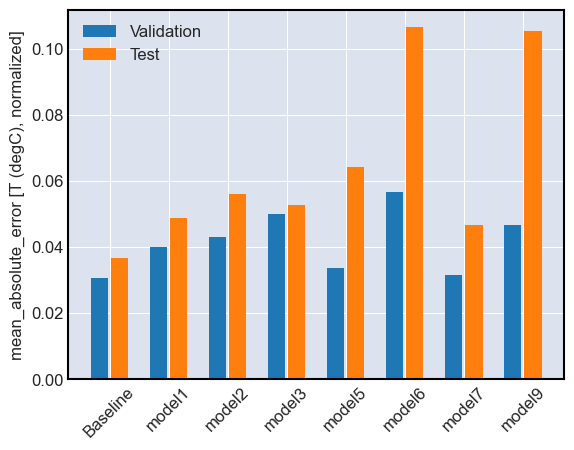

In [46]:
x = np.arange(len(performance))
width = 0.3
metric_name = 'mean_absolute_error'
metric_index = model9.metrics_names.index('mean_absolute_error')
val_mae = [v[metric_index] for v in val_performance.values()]
test_mae = [v[metric_index] for v in performance.values()]

plt.ylabel('mean_absolute_error [T (degC), normalized]')
plt.bar(x - 0.17, val_mae, width, label='Validation')
plt.bar(x + 0.17, test_mae, width, label='Test')
plt.xticks(ticks=x, labels=performance.keys(),
           rotation=45)
_ = plt.legend()

model 1,2,3 looks good but the best of it will be *model1*

# Testing the model 

In [47]:
test_acc_in=[]
model_in=[]
test_loss, test_acc = model1.evaluate(w5.test)
test_acc_in.append(test_acc)
model_in.append('model1')
test_loss, test_acc = model2.evaluate(w10.test)
test_acc_in.append(test_acc)
model_in.append('model2')
test_loss, test_acc = model3.evaluate(w10.test)
test_acc_in.append(test_acc)
model_in.append('model3')
test_loss, test_acc = model5.evaluate(w5.test)
test_acc_in.append(test_acc)
model_in.append('model5')
test_loss, test_acc = model6.evaluate(w10.test)
test_acc_in.append(test_acc)
model_in.append('model6')
test_loss, test_acc = model7.evaluate(w10.test)
test_acc_in.append(test_acc)
model_in.append('model7')
test_loss, test_acc = model9.evaluate(w10.test)
test_acc_in.append(test_acc)
model_in.append('model9')
accuracy={'test_acc':test_acc_in, 'model':model_in}
accuracy=pd.DataFrame(accuracy)
accuracy

16/16 [==============================] - 0s 13ms/step - loss: 0.0151 - mean_absolute_error: 0.1054


,test_acc,model
0,0.048911,model1
1,0.056179,model2
2,0.052687,model3
3,0.064189,model5
4,0.106449,model6
5,0.046652,model7
6,0.105358,model9


# Retraining model1 as DAN_EURUSD on all the dataset

In [48]:
df_mean = df.mean()
df_std = df.std()
df = (df - df_mean) / df_std

class WindowGeneratorT():
    def __init__(self, input_width, label_width, shift,
                 df=df, label_columns=None):
        # Store the raw data.
        self.df = df
        # Work out the label column indices.
        self.label_columns = label_columns
        if not label_columns == None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
            self.column_indices = {name: i for i, name in enumerate(df.columns)}
        # Work out the window parameters.
        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift
        self.total_window_size = input_width + shift
        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]
        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]
    def __repr__(self):
        return '\n'.join([f'Total window size: {self.total_window_size}', 
                          f'Input indices: {self.input_indices}',
                          f'Label indices: {self.label_indices}',
                          f'Label column name(s): {self.label_columns}'])
    
WindowGeneratorT.split_window = split_window
WindowGeneratorT.make_dataset = make_dataset

@property
def trainT(self):
    return self.make_dataset(self.df)

WindowGeneratorT.trainT = trainT
win=WindowGeneratorT(input_width=5, label_width=5, shift=1, label_columns=['Open'])

DAN_EURUSD=tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(5, 10), name='convid_2_input'),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, activation='relu', name='convid_2'),
    tf.keras.layers.MaxPooling1D(pool_size=3, name='max_pooling_1d'),
    tf.keras.layers.Flatten(name='flatten_2'),
    tf.keras.layers.Dense(10, activation='relu', name='dense_4'),
    tf.keras.layers.Dense(5, name='dense_5')])
DAN_EURUSD.compile(loss=tf.keras.losses.MeanSquaredError(), 
               optimizer=tf.keras.optimizers.Adam(),
               metrics=[tf.keras.metrics.MeanAbsoluteError()])
DAN_EURUSD.fit(win.trainT, epochs=20, batch_size=4)

DAN_EURUSD.save('DAN_EURUSD_model')

Epoch 1/20
159/159 [==============================] - 3s 4ms/step - loss: 0.2345 - mean_absolute_error: 0.2997
Epoch 2/20
159/159 [==============================] - 1s 4ms/step - loss: 0.0135 - mean_absolute_error: 0.0842
Epoch 3/20
159/159 [==============================] - 1s 4ms/step - loss: 0.0090 - mean_absolute_error: 0.0659
Epoch 4/20
159/159 [==============================] - 1s 5ms/step - loss: 0.0072 - mean_absolute_error: 0.0578
Epoch 5/20
159/159 [==============================] - 1s 5ms/step - loss: 0.0062 - mean_absolute_error: 0.0532
Epoch 6/20
159/159 [==============================] - 1s 5ms/step - loss: 0.0056 - mean_absolute_error: 0.0499
Epoch 7/20
159/159 [==============================] - 1s 5ms/step - loss: 0.0053 - mean_absolute_error: 0.0479
Epoch 8/20
159/159 [==============================] - 1s 5ms/step - loss: 0.0050 - mean_absolute_error: 0.0463
Epoch 9/20
159/159 [==============================] - 1s 5ms/step - loss: 0.0048 - mean_absolute_error: 0.0454
E

INFO:tensorflow:Assets written to: DAN_EURUSD_model\assets


INFO:tensorflow:Assets written to: DAN_EURUSD_model\assets


In [58]:
def DAN_EURUSD_predict(sample_df, Date=[],forecast={}):
    sample_df=clean_feature_eng(sample_df)
    sample_df= (sample_df - df_mean) / df_std
    sample_df = np.array(sample_df, dtype=np.float32)
    sample_df = np.expand_dims(sample_df, axis=0)
    predictions = DAN_EURUSD.predict(sample_df)
    predictions = (predictions*0.1)+1
    now=datetime.datetime.now() 
    next_monday = now  + datetime.timedelta(days=(7 - now.weekday()))
    dates = [next_monday + datetime.timedelta(days=i) for i in range(5)]
    for date in dates:
        Date.append(date.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] + 'Z')
    Date=pd.to_datetime(Date)
    forecast['Date']=Date
    forecast['Open']=np.ravel(predictions)
    forecast['High']=np.ravel(predictions)+np.random.uniform(low=0.0, high=0.001)
    forecast['Low']= np.ravel(predictions)-np.random.uniform(low=0.0, high=0.001)
    Close=[forecast['Open'][1:],forecast['Open'][0]]
    Close=np.concatenate((Close[0], np.array([Close[1]]).reshape(1)))
    forecast['Close']=Close
    forecast['Volume']=[0.0,0.0,0.0,0.0,0.0]
    forecast['Dividends']=[0.0,0.0,0.0,0.0,0.0]
    forecast['Stock Splits']=[0.0,0.0,0.0,0.0,0.0]
    forecast= pd.DataFrame(forecast)
    forecast.set_index('Date', inplace=True)
    mpf.plot(forecast, type='candle', style='charles', volume=False)
    return forecast

In [59]:
eurusd = yf.Ticker("EURUSD=X")
sample = eurusd.history(period="max")
acc=sample.tail(5)

1/1 [==============================] - 0s 44ms/step


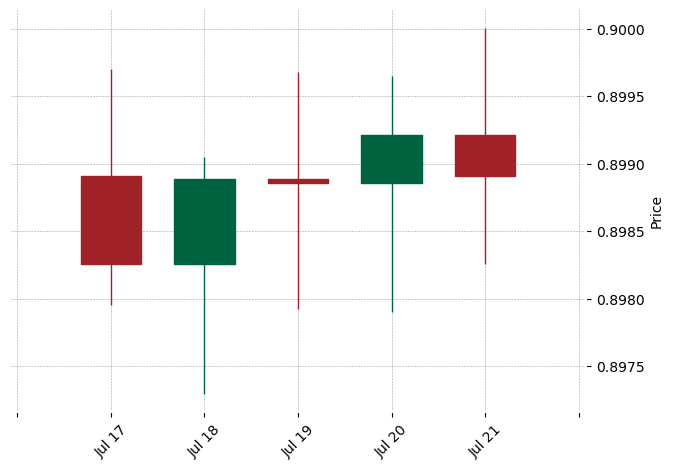

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2023-07-17 21:05:33.494000+00:00,0.898913,0.899706,0.897955,0.898255,0.0,0.0,0.0
2023-07-18 21:05:33.494000+00:00,0.898255,0.899048,0.897297,0.898886,0.0,0.0,0.0
2023-07-19 21:05:33.494000+00:00,0.898886,0.899679,0.897928,0.898859,0.0,0.0,0.0
2023-07-20 21:05:33.494000+00:00,0.898859,0.899652,0.897901,0.899215,0.0,0.0,0.0
2023-07-21 21:05:33.494000+00:00,0.899215,0.900008,0.898257,0.898913,0.0,0.0,0.0


In [60]:
forecast=DAN_EURUSD_predict(acc)
forecast

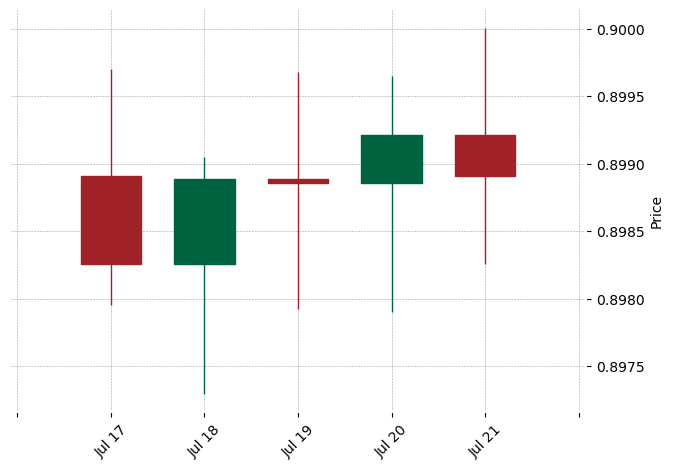

In [61]:
mpf.plot(forecast, type='candle', style='charles', volume=False)